<a href="https://colab.research.google.com/github/aghosh92/SISSO_sGP/blob/main/SiSSO_sGP_QM9_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows how to visualize the results from the SISSO_sGP workflow as performed on QM9 dataset to reconstruct the formation enthalpy for all molecules.

Email: research.aghosh@gmial.com

## Imports

In [2]:
from typing import List

import numpy as np
import glob
import wget
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import zipfile

In [39]:
#@title Helper functions
def update_record(record: np.ndarray, action: int, r: float) -> np.ndarray:
    new_r = (record[action, 0] * record[action, 1] + r) / (record[action, 0] + 1)
    record[action, 0] += 1
    record[action, 1] = new_r
    return record


def get_reward(obj_history: List[float], obj: np.ndarray) -> int:
    """A reward of +/-1 is given if the integral uncertainty at the current step
    is smaller/larger than the integral uncertainty at the previous step"""
    if np.nanmedian(obj) < obj_history[-1]:
        r = 1
    else:
        r = -1
    return r

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
#clone into github repo
!git clone https://github.com/aghosh92/SISSO_sGP

Cloning into 'SISSO_sGP'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 134 (delta 10), reused 0 (delta 0), pack-reused 112
Receiving objects: 100% (134/134), 23.72 MiB | 10.96 MiB/s, done.
Resolving deltas: 100% (56/56), done.


## Load data

In [31]:
path = "/content/SISSO_sGP/results/QM9_*/"
filepath1 = path + "history.npz"
filepath2 = path + "records_misc.npz"

filelist1 = glob.glob(filepath1)
filelist2 = glob.glob(filepath2)

## Averaged results

In [32]:
records_all = []
model_ids = []
for f1, f2 in zip(filelist1, filelist2):
    history = np.load(f1)
    records_all.append(history['record'][:, -1])
    misc = np.load(f2)
    model_ids.append(misc["model_ids"])
records_all = np.array(records_all)

records_all.mean(0)

array([ 0.10893564,  0.22452144, -0.4337852 ])

In [33]:
len(filelist1)

5

In [34]:
records_all

array([[ 0.38      ,  0.27586207, -0.48484848],
       [ 0.07692308,  0.57251908, -0.56756757],
       [-0.26190476,  0.37583893, -0.5862069 ],
       [ 0.43537415, -0.45      , -0.36363636],
       [-0.08571429,  0.3483871 , -0.16666667]])

## Explore individual runs

QM9_1_run
[-0.08571429  0.3483871  -0.16666667]


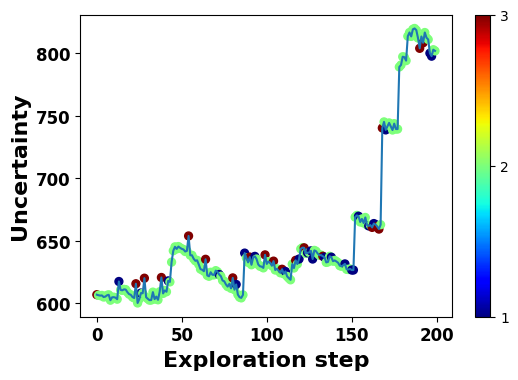

In [36]:
k = 4

history = np.load(filelist1[k])
misc = np.load(filelist2[k])

U_history = history['obj_history']
model_ids = misc['model_ids']

plt.figure(dpi=100)
plt.plot(np.arange(len(U_history)), U_history)
plt.scatter(np.arange(len(U_history)), U_history, s=32, 
            c=[m+1 for m in model_ids], cmap='jet')
plt.ylabel('Uncertainty',fontdict={'fontsize' : 16, "weight" :"bold"})
plt.xlabel("Exploration step",fontdict={'fontsize' : 16, "weight" :"bold"})
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight = 'bold')
cbar = plt.colorbar()
cbar.set_ticks([1, 2, 3])
print(filelist1[k].split('/')[-2])
print(history["record"][:, -1])

Although we save only final rewards, we can easily retrace the rewards history.

Retrace the rewards history:

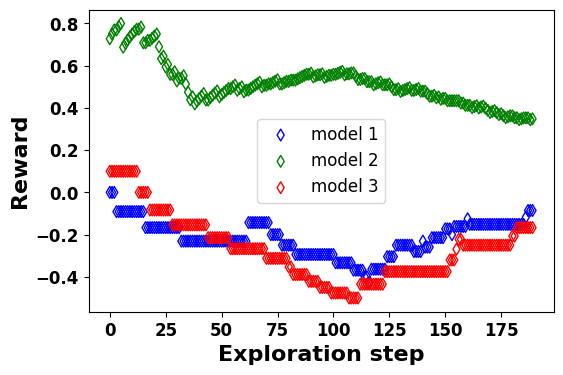

In [40]:
# compute rewards after warm-up steps
record = np.zeros((3, 2))
record[:, 0] = 10  # we used 10 warm-up states
for i in model_ids[:10]:
    record[i, 1] += 1
record[:, 1] /= 10  # average over all the warm-up states

rewards_history = []
for j, (u, i) in enumerate(zip(U_history[10:], model_ids[10:])):
    r = get_reward(U_history[9:10+j], u)
    record = update_record(record, i, r)
    rewards_history.append(record[:, 1].copy())
rewards_history = np.array(rewards_history)

plt.figure(dpi=100)
x = np.arange(len(rewards_history))
colors = ['b', 'g', 'r']
for i in range(3):
    plt.scatter(x, rewards_history[:, i], marker = 'd', label='model {}'.format(i+1),facecolors='none', edgecolors=colors[i])
plt.xlabel('Exploration step',fontdict={'fontsize' : 16, "weight" :"bold"})
plt.ylabel('Reward',fontdict={'fontsize' : 16, "weight" :"bold"})
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight = 'bold')
plt.legend(fontsize=12)